In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_excel("标地净值.xlsx")

In [3]:
df.head()

,日期,中欧医疗A净值,中欧医疗A,中证白酒A净值,中证白酒A,易方达蓝筹净值,易方达蓝筹,国泰新能源净值,国泰新能源,国泰食品净值,国泰食品,富国成长净值,富国成长,兴全和润净值,兴全和润,汇添富消费ETF净值,汇添富消费ETF,易方达沪深300净值,易方达沪深300
0,2021-08-19,3.7715,0.009720,4.6595,-0.012480,2.4838,-0.015303,2.3570,0.029932,4.7683,-0.012657,21.3302,-0.002587,7.6463,0.008274,2.8005,-0.013700,1.7655,-0.006136
1,2021-08-18,3.7352,0.004438,4.7184,0.005749,2.5224,0.013541,2.2885,0.005183,4.8295,-0.000349,21.3856,0.007408,7.5836,0.001255,2.8394,0.001164,1.7764,0.011099
2,2021-08-17,3.7187,-0.048423,4.6914,-0.046188,2.4887,-0.032312,2.2767,-0.012149,4.8312,-0.038268,21.2283,-0.022553,7.5741,-0.024873,2.8361,-0.036520,1.7569,-0.019642
3,2021-08-16,3.9079,-0.015521,4.9186,0.002555,2.5718,-0.006528,2.3047,-0.037221,5.0234,0.005146,21.7181,-0.000429,7.7673,0.002897,2.9436,0.003888,1.7921,-0.000390
4,2021-08-13,3.9695,0.000277,4.9061,0.007961,2.5887,-0.000386,2.3938,-0.006310,4.9977,0.004917,21.7274,-0.001086,7.7448,-0.001471,2.9322,0.003285,1.7928,-0.005105


In [4]:
import math
price = [x for x in df['汇添富消费ETF净值'].tolist() if math.isnan(x) == False]
price.reverse()
len(price)

1533

In [5]:
gain = [x for x in df['汇添富消费ETF'].tolist() if math.isnan(x) == False]
gain.reverse()
len(gain)

1533

In [6]:
from datetime import datetime
date = [datetime.strptime(x, "%Y-%m-%d") for x in df['日期'].tolist()]
date.reverse()
date[:5]

[datetime.datetime(2005, 11, 16, 0, 0),
 datetime.datetime(2005, 11, 17, 0, 0),
 datetime.datetime(2005, 11, 18, 0, 0),
 datetime.datetime(2005, 11, 21, 0, 0),
 datetime.datetime(2005, 11, 22, 0, 0)]

In [7]:
def get_date_action(dd):
    """计算周，双周，月，年的执行买入点，1为新周期买入时间点，0为不买入
       dd 是Wind导出的日期数据（经过datetime模组处理）
       导出List，List[0]为周，List[1]为双周，List[2]为月，List[3]为年
    """
    weekday = [x.weekday()+1 for x in dd] #各日期的 周-月-年 数据
    month = [x.month for x in dd]
    year = [x.year for x in dd]
    
    action_week = [0]                        #计算周的买入点，逻辑为：当下一天星期几数据不再增加时算新的一周
    for x in range(1,len(weekday)):          #例：1,2,3,4,5,1,2 或 1,2,3,4,4  分别在 5 - 1 和 4 - 4 时计算后者为新一周，执行买入
        previous = weekday[x-1]
        if weekday[x] <= previous:
            action_week.append(1)
        else:
            action_week.append(0)
    
    action_doubleWeek = []                  #计算双周的买入点，逻辑为：根据单周买入执行数据，忽略中间的执行
    net = 0
    for x in range(len(action_week)):
        net += action_week[x]
        if net == 2:
            action_doubleWeek.append(1)
            net = 0
        else:
            action_doubleWeek.append(0)
    
    action_month = [0]                      #计算月的买入点，逻辑为：当下一天月份数据变化时算新的一月
    for x in range(1,len(month)):
        previous = month[x-1]
        if month[x] != previous:
            action_month.append(1)
        else:
            action_month.append(0)
    
    action_year = [0]                      #计算年的买入点，逻辑为：当下一天年份数据变化时算新的一年
    for x in range(1,len(year)):
        previous = year[x-1]
        if year[x] != previous:
            action_year.append(1)
        else:
            action_year.append(0)
    
    return [action_week, action_doubleWeek, action_month, action_year]

In [8]:
actions = get_date_action(date)

In [9]:
actions[0][:20] #周买入执行点

[0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0]

In [10]:
actions[1][:20] #双周执行点

[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]

In [11]:
actions[2][:20] #月执行点

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]

In [12]:
def avg_line(unitCA,unit,ddd,freq = 0,hold = 1,cycle = 0,begin = 4,avgl = 30):
    """unitCA 是基金成立以来的复权单位净值
       ddd 是基金净值对应的日期数据
       freq 是智能定投的频率，0代表周，1代表双周，2代表月，默认为周 （对应get_date_action函数）
       hold 是智能定投的市场（年），默认为一年
       cycle 是脚本的滚动计算智能定投收益率频率，0代表周，1代表双周，2代表月，默认为周（对应get_date_action函数）
       begin 是所参考的复权单位净值的取值范围（年），默认为两年（大于hold）
       avgl 是均线所取的范围（天），默认为100天
       数据List，List[0]为智能定投收益率，List[1]为普通定投收益率，List[2]为每次定投金额
    """
    ###根据get_date_action函数日期计算各频率买入点 #####################################
    act = get_date_action(ddd)
    freq_action = act[freq]   #选取总定投买入频率
    cycle_action = act[cycle] #选取总滚动定投频率


    ###选取起始定投点以及滚动开始点，逻辑：根据周买入点从后往前滚动 52周为 1年 #############
    week = 0
    hold_ind = 0
    for action in range(len(act[0])-1,0,-1):
        week += act[0][action]
        if week == int(52 * hold):              #当Week持续累计 52周 x 持有期（年），停止
            hold_ind = action
    
    week = 0
    begin_ind = 0
    for action in range(len(act[0])-1,0,-1):
        week += act[0][action]
        if week == int(52 * begin):            #当Week持续累计 52周 x 滚动期（年），停止
            begin_ind = action
            begin_unitCA = len(unitCA) - len(act[0]) + action
        
        
    #print(len(unitCA),begin_unitCA)
    #print(ddd[begin_ind])
    
    #print("len(date):",len(date))
    #print("len(unitCA):",len(unitCA))
    #print("begin_ind:",begin_ind)
    #print("hold_ind:",hold_ind)
    ###根据净值计算资产的每日涨跌幅 #####################################################
    #gain_unitCA = [0]               #第一天为0，涨跌幅对齐净值数据
    #for x in range(0,len(unitCA)-1):
        #gain_unitCA.append((unitCA[x+1] - unitCA[x]) / unitCA[x])
        

    ###滚动收益率的计算 ################################################################
    cycle_period = cycle_action[begin_ind:]          #从总滚动定投频率选择滚动起始点
    cycled_gain = []                      #储存 智能定投 滚动收益率
    Ncycled_gain = []                     #储存 普通定投 滚动收益率
    amount = []                           #储存 智能定投 每次的投资金额，loop次数 x 定投次数 的矩阵
    
    abs_gain = []
    Nabs_gain = []
    
    #print("sum(cycle_period)-52*hold:",sum(cycle_period)-52*hold)
    for cycle in range(sum(cycle_period)-int(52*hold)):   #记录每次滚动收益率的loop，从起始点到（最大时间点 - 持有期），确保每次loop的持有期一致
        cycle_ind = 0
        cycle_fill = 0
        for x in range(len(cycle_period)):           #cycle为滚动的次序，0为第一次滚动，所以当累计到 1时就是当前滚动开始的时间点
            cycle_fill += cycle_period[x]
            if cycle_fill == cycle + 1:
                cycle_ind = x
                break
        
        cycle_end_ind = 0
        cycle_fill_end = 0
        for x in range(cycle_ind,len(cycle_period)):
            cycle_fill_end += cycle_period[x]
            if cycle_fill_end == 52 * hold + 1:
                cycle_end_ind = x
                break
        
        cost = 0                         #智能定投总成本
        endVal = 0                       #最终智能定投净值
        
        Ncost = 0                        #普通定投成本
        NendVal = 0                      #普通定投净值
        
        cost_line = []                   #每次滚动的定投金额
        NendVal_line = []
        avg_line = []
        
        cost_line_eve = []
        endVal_line = []
        devia = []
        cum_cost = []
        Ncum_cost = []
        eve_return = []
        Neve_return = []
        
        #print(begin_ind,cycle_ind,cycle_end_ind)
        #ind = len(unitCA) - (len(freq_action) - begin_ind)   #选取当前滚动计算的净值区间
        begin_end = unitCA[begin_unitCA + cycle_ind : begin_unitCA + cycle_end_ind]
        buy_period = freq_action[begin_ind + cycle_ind : begin_ind + cycle_end_ind]                 #选取当前滚动计算的买入点区间
        asset_period = unit[begin_unitCA + cycle_ind : begin_unitCA + cycle_end_ind]

        ###计算每次滚动智能定投和普通定投的收益率 #########################################
        buy = [2000,1800,1600,1400,1200,1000,800,600]
        for x in range(0,len(buy_period)-1):
            
            if buy_period[x] == 1:
                avg_period = unit[max(begin_unitCA + cycle_ind - avgl + x,0) : begin_unitCA + cycle_ind + x]
                avg = np.mean(avg_period)                                                                      #如果当天为买入点时，计算均线平均，净值区间倒退 均线 天数，再加上已经loop过的天 = 当前的均线平均
                deviats = []
                for y in avg_period:
                    deviats.append(y / avg - 1)
                
                deviats = np.sort(deviats)

                "智能定投的逻辑1"
                """偏差区间对应的投资金额：
                    [-10%+, -5%~-10%, +-5%, 5%+]
                   [2000 ,   1400  , 1000,  600 ]
                """
                r = (asset_period[x]/avg) - 1                 #计算当前净值超出平均线的部分
                if r < deviats[0]:                               #计算对应投资的金额
                    invest = buy[0]
                elif r >= deviats[0] and r < deviats[avgl // len(buy) * 1]:
                    invest = buy[1]
                elif r >= deviats[avgl // (len(buy)+1) * 1] and r < deviats[avgl // (len(buy)+1) * 2]:
                    invest = buy[2]
                elif r >= deviats[avgl // (len(buy)+1) * 2] and r < deviats[avgl // (len(buy)+1) * 3]:
                    invest = buy[3]
                elif r >= deviats[avgl // (len(buy)+1) * 3] and r < deviats[avgl // (len(buy)+1) * 4]:
                    invest = buy[4]
                elif r >= deviats[avgl // (len(buy)+1) * 4] and r < deviats[avgl // (len(buy)+1) * 5]:
                    invest = buy[5]
                elif r >= deviats[avgl // (len(buy)+1) * 6] and r < deviats[avgl // (len(buy)+1) * 7]:
                    invest = buy[6]
                else:
                    invest = buy[7]
                    
                
                cost_line_eve.append(invest)
                endVal_line.append(endVal)
                NendVal_line.append(NendVal)
                avg_line.append(avg)
                devia.append(r)
                
                if cost == 0:
                    eve_return.append(0)
                    Neve_return.append(0)
                else:
                    eve_return.append((endVal - cost) / cost)
                    Neve_return.append((NendVal - Ncost) / Ncost)
                cum_cost.append(cost)
                Ncum_cost.append(Ncost)
                
                cost_line.append(invest)              #更新各项数据
                cost += invest
                endVal += invest
                
                #cum_cost.append(cost)
                eve_return
                
                Ncost += 1000                             #普通定投每次都默认为1000元
                NendVal += 1000
                #Ncum_cost.append(Ncost)
                #Neve_return.append((NendVal - Ncost) / Ncost)
            
            else:
                cum_cost.append(cost)
                Ncum_cost.append(Ncost)
                if cost == 0:
                    eve_return.append(0)
                    Neve_return.append(0)
                else:
                    eve_return.append((endVal - cost) / cost)
                    Neve_return.append((NendVal - Ncost) / Ncost)
                
                invest = 0
                cost += invest
                endVal += invest
                
                Ncost += invest                             #普通定投每次都默认为1000元
                NendVal += invest
                
                cost_line_eve.append(invest)              #更新各项数据
                endVal_line.append(endVal)
                NendVal_line.append(NendVal)
                avg_line.append(invest)
                devia.append(invest)
                
            
            endVal = endVal * (1 + begin_end[x+1])        #更新每日收益率之后进行下一个loop
            NendVal = NendVal * (1 + begin_end[x+1])

        total_gain = (endVal - cost) /  endVal            #计算收益率
        Ntotal_gain = (NendVal - Ncost) /  NendVal
        #print(endVal - cost,NendVal - Ncost)
        cycled_gain.append(total_gain)                    #更新汇总数据
        Ncycled_gain.append(Ntotal_gain)
        
        abs_gain.append(endVal - cost)
        Nabs_gain.append(NendVal - Ncost)
        
        
        
        
        
        
        cor_day = ddd[begin_ind + cycle_ind : begin_ind + cycle_end_ind]
        
        
        amount.append(cor_day)
        amount.append(begin_end)
        amount.append(asset_period)
        amount.append(avg_line)
        amount.append(devia)
        amount.append(cost_line_eve)
        
        amount.append(cum_cost)
        amount.append(endVal_line)
        amount.append(eve_return)
        
        amount.append(Ncum_cost)
        amount.append(NendVal_line)
        amount.append(Neve_return)
        #amount.append(cost_line.append(total_gain))
        
        #amount.append(cost_line)
    
    avg_abs = np.mean(abs_gain)
    avg_Nabs = np.mean(Nabs_gain)
    
    return([cycled_gain,Ncycled_gain,amount,avg_abs,avg_Nabs])

In [13]:
result = avg_line(gain,price,date) #计算中欧医疗A在默认设定下的定投对比

In [14]:
example = pd.DataFrame(result[2])

In [15]:
example = example.T

In [16]:
example[example.columns[0:20]].head(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,2017-07-03,-0.01029,1.2023,1.159667,0.036763,600,0,0,0,0,0,0,2017-07-10,0.007718,1.1882,1.171703,0.014079,800,0,0
1,2017-07-04,-0.014389,1.185,0,0,0,600,591.3666,-0.014389,1000,985.611,-0.014389,2017-07-11,0.007911,1.1976,0,0,0,800,806.3288
2,2017-07-05,0.009705,1.1965,0,0,0,600,597.105813,-0.004824,1000,995.176355,-0.004824,2017-07-12,-0.009269,1.1865,0,0,0,800,798.854938
3,2017-07-06,-0.005182,1.1903,0,0,0,600,594.011611,-0.009981,1000,990.019351,-0.009981,2017-07-13,-0.002023,1.1841,0,0,0,800,797.238855
4,2017-07-07,-0.009409,1.1791,0,0,0,600,588.422555,-0.019296,1000,980.704259,-0.019296,2017-07-14,0.003463,1.1882,0,0,0,800,799.999693
5,2017-07-10,0.007718,1.1882,1.171703,0.014079,800,600,592.964001,-0.011727,1000,988.273334,-0.011727,2017-07-17,-0.022387,1.1616,1.182403,-0.017594,1600,800,782.0901
6,2017-07-11,0.007911,1.1976,0,0,0,1400,1403.983739,0.002846,2000,2004.002565,0.002001,2017-07-18,0.003874,1.1661,0,0,0,2400,2391.318317
7,2017-07-12,-0.009269,1.1865,0,0,0,1400,1390.970214,-0.00645,2000,1985.427465,-0.007286,2017-07-19,0.012606,1.1808,0,0,0,2400,2421.463276
8,2017-07-13,-0.002023,1.1841,0,0,0,1400,1388.156281,-0.00846,2000,1981.410945,-0.009295,2017-07-20,0.011433,1.1943,0,0,0,2400,2449.147865
9,2017-07-14,0.003463,1.1882,0,0,0,1400,1392.963466,-0.005026,2000,1988.272571,-0.005864,2017-07-21,0.006615,1.2022,0,0,0,2400,2465.348978


In [17]:
len(example.columns)

1872

In [18]:
example[example.columns[:25]].to_excel('抽查2.xlsx')

In [19]:
np.mean(result[0])

0.12800600228623954

In [20]:
np.mean(result[1])

0.11707634773536595

In [21]:
diff = [result[0][x] - result[1][x] for x in range(len(result[0]))]
winrate = sum([1 for x in diff if x > 0]) / len(result[0])
winrate #相比于普通定投的胜率

0.8205128205128205

In [22]:
lost = [x for x in range(len(diff)) if diff[x]<0]
lost

[0,
 1,
 2,
 3,
 4,
 5,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146]

In [23]:
lost_example = []
for x in lost:
    for y in range(12):
        lost_example.append(result[2][x * 12 + y])
le = pd.DataFrame(lost_example).T

In [24]:
le.to_excel('抽查输2.xlsx')
le.head(10)

,0,1,2,3,4,5,6,7,8,9,...,326,327,328,329,330,331,332,333,334,335
0,2017-07-03,-0.01029,1.2023,1.159667,0.036763,600,0,0,0,0,...,2.2978,2.199077,0.044893,600,0,0,0,0,0,0
1,2017-07-04,-0.014389,1.185,0,0,0,600,591.3666,-0.014389,1000,...,2.2848,0,0,0,600,596.6052,-0.005658,1000,994.342,-0.005658
2,2017-07-05,0.009705,1.1965,0,0,0,600,597.105813,-0.004824,1000,...,2.2731,0,0,0,600,593.549985,-0.01075,1000,989.249975,-0.01075
3,2017-07-06,-0.005182,1.1903,0,0,0,600,594.011611,-0.009981,1000,...,2.2907,0,0,0,600,598.145842,-0.00309,1000,996.909737,-0.00309
4,2017-07-07,-0.009409,1.1791,0,0,0,600,588.422555,-0.019296,1000,...,2.2881,0,0,0,600,597.466947,-0.004222,1000,995.778245,-0.004222
5,2017-07-10,0.007718,1.1882,1.171703,0.014079,800,600,592.964001,-0.011727,1000,...,2.3005,2.227803,0.032632,600,600,600.70462,0.001174,1000,1001.174367,0.001174
6,2017-07-11,0.007911,1.1976,0,0,0,1400,1403.983739,0.002846,2000,...,2.3188,0,0,0,1200,1210.256225,0.008547,2000,2017.093709,0.008547
7,2017-07-12,-0.009269,1.1865,0,0,0,1400,1390.970214,-0.00645,2000,...,2.3225,0,0,0,1200,1212.187794,0.010156,2000,2020.312991,0.010156
8,2017-07-13,-0.002023,1.1841,0,0,0,1400,1388.156281,-0.00846,2000,...,2.2827,0,0,0,1200,1191.414532,-0.007155,2000,1985.690887,-0.007155
9,2017-07-14,0.003463,1.1882,0,0,0,1400,1392.963466,-0.005026,2000,...,2.2926,0,0,0,1200,1196.581697,-0.002849,2000,1994.302828,-0.002849


In [25]:
sum(diff) / len(result[0])

0.0109296545508736

In [26]:
def get_graph(unit,ddd,begin = 1):
    avgl = [10,30,60,120]
    result = [[] for x in range(len(avgl))]
    
    date = ddd[len(ddd) - len(unit):]
    for l in range(len(avgl)):
        y = abs(250 * begin - len(unit))
        used_unit = unit[y + avgl[l]:]
        used_date = date[y + avgl[l]:]
        nest = [[] for x in range(3)]
        nest[0] = used_unit
        for num in range(len(used_unit)):
            avg = np.mean(unit[max(len(unit) - len(used_unit) - avgl[l] + num,0) : len(unit) - len(used_unit) + num])
            #print(max(len(unit) - len(used_unit) - avgl[l],0),num + avgl[l])
            r = (used_unit[num]/avg) - 1
            nest[1].append(avg)
            nest[2].append(r)
        result[l] = nest
    
    return result

In [27]:
graphs = get_graph(price,date,6)

In [28]:
graphs[0][1][-10:-1]

[2.8729500000000003,
 2.84739,
 2.84437,
 2.8628600000000004,
 2.8764700000000003,
 2.88629,
 2.9048899999999995,
 2.9129099999999997,
 2.9064300000000003]

In [29]:
price[-10:-1]

[2.828, 2.9101, 3.0192, 2.9733, 2.9226, 2.9322, 2.9436, 2.8361, 2.8394]

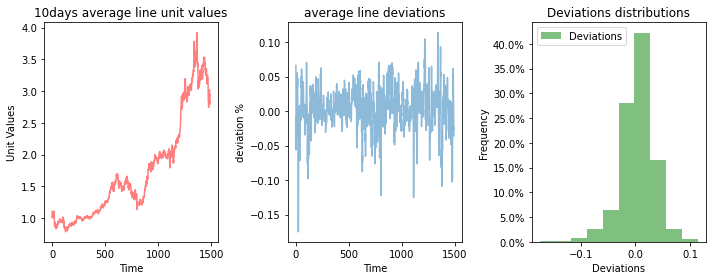

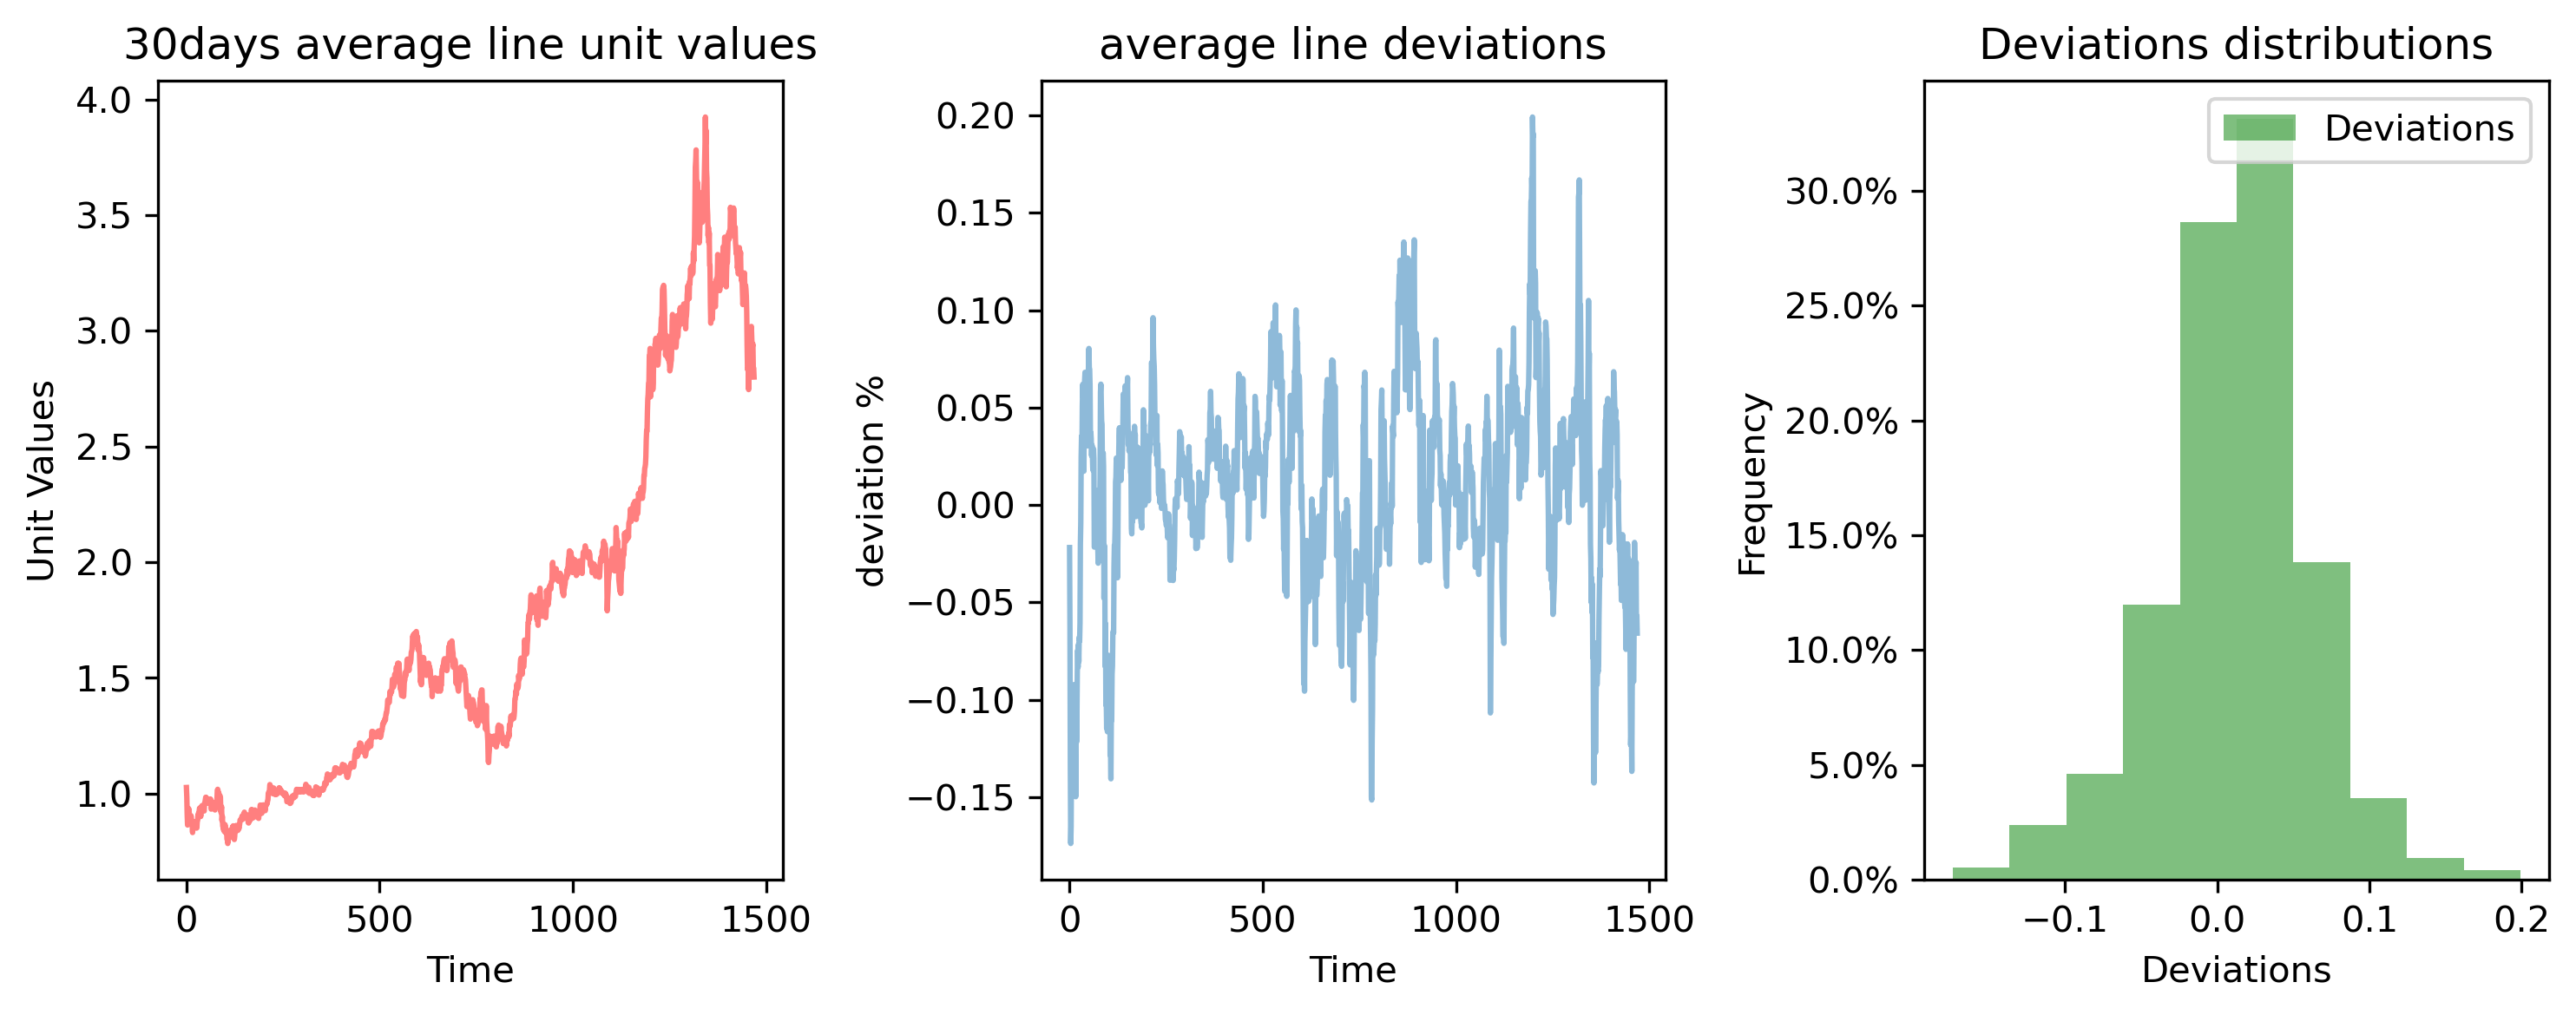

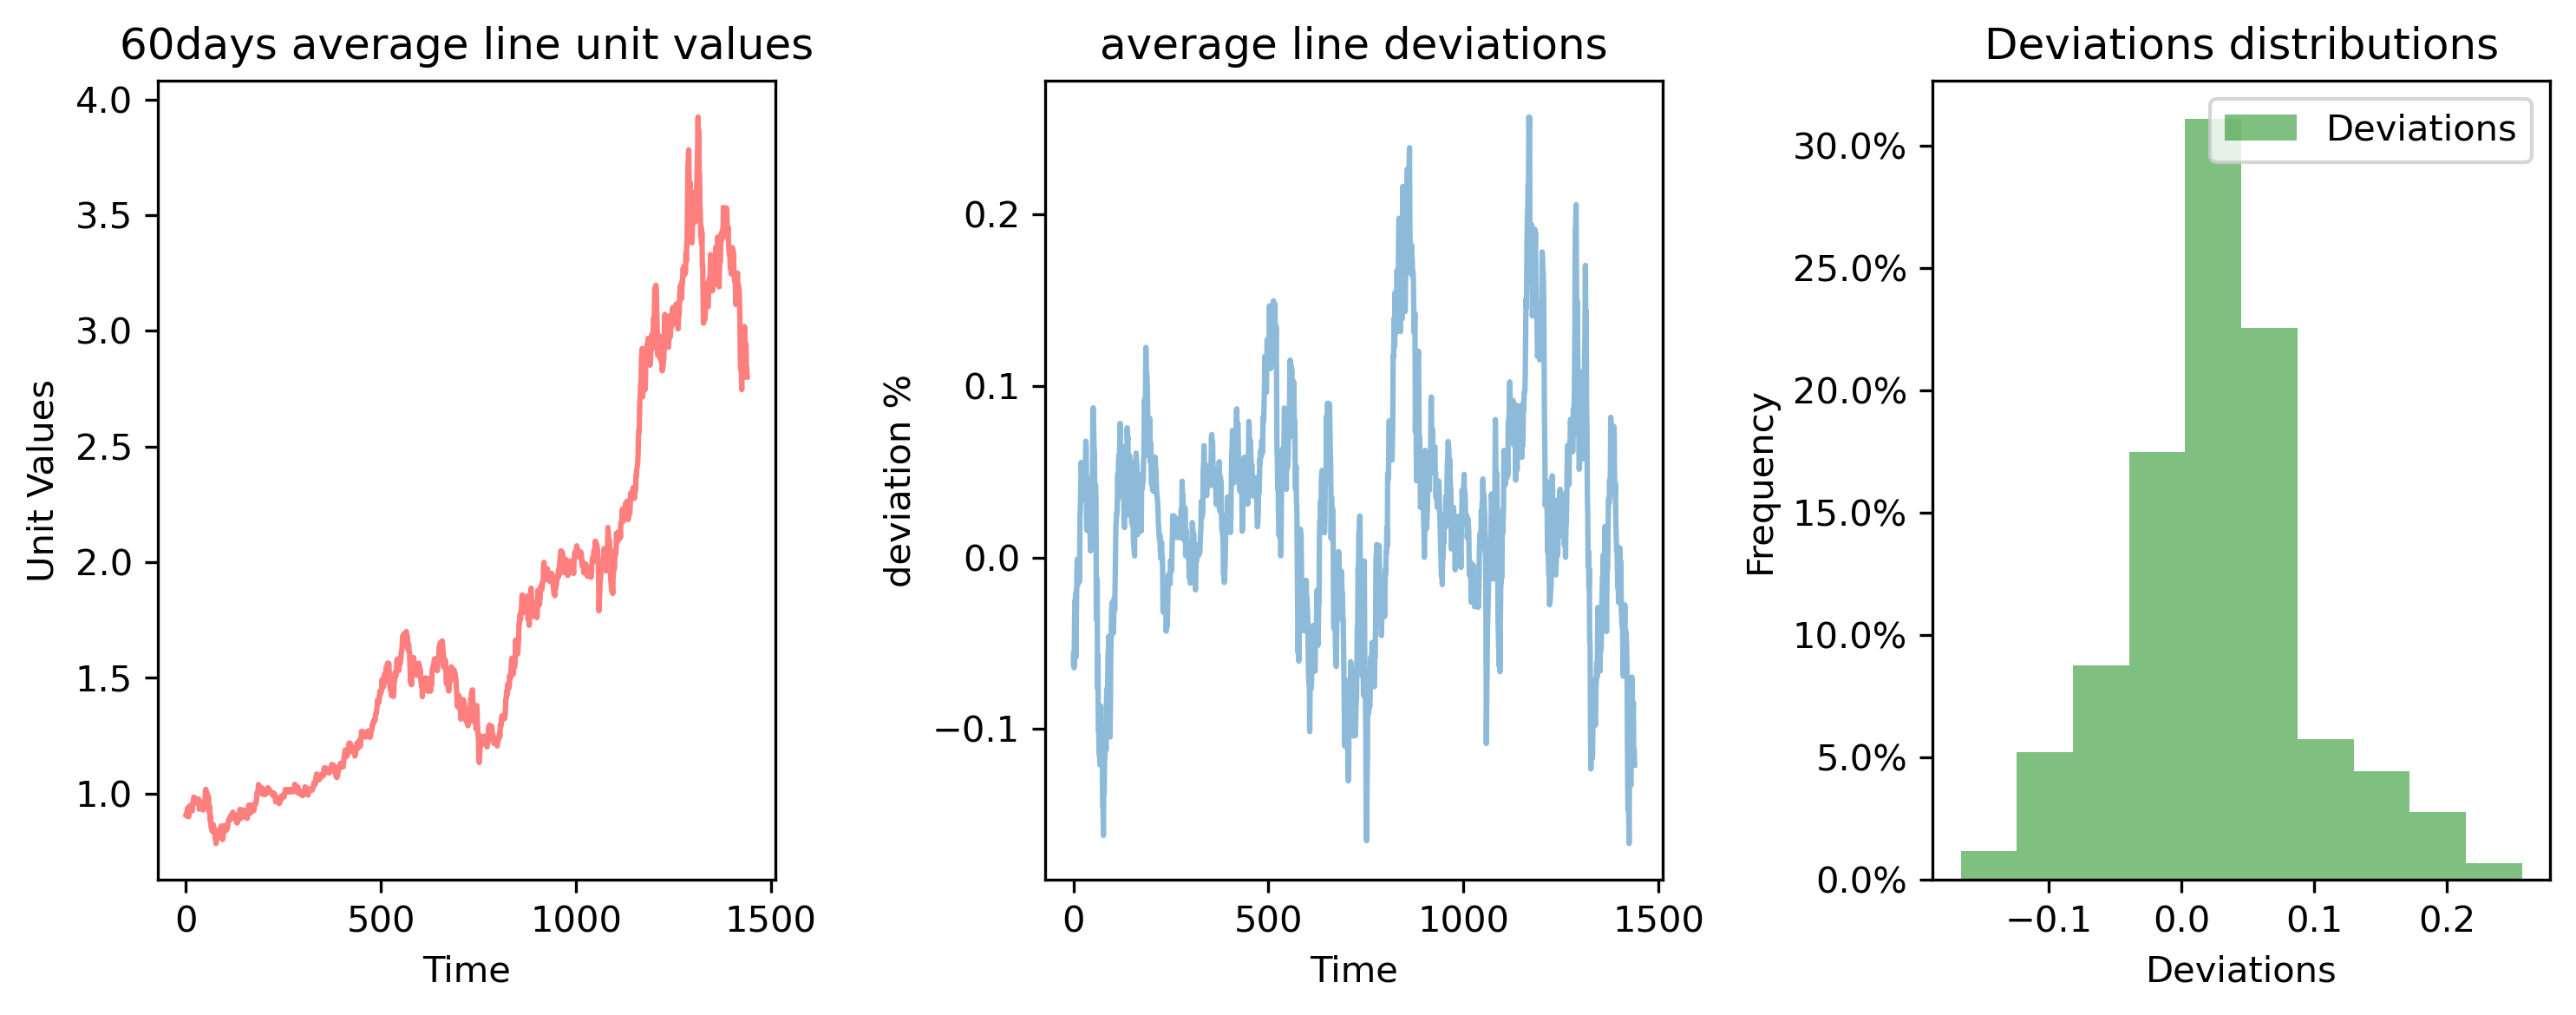

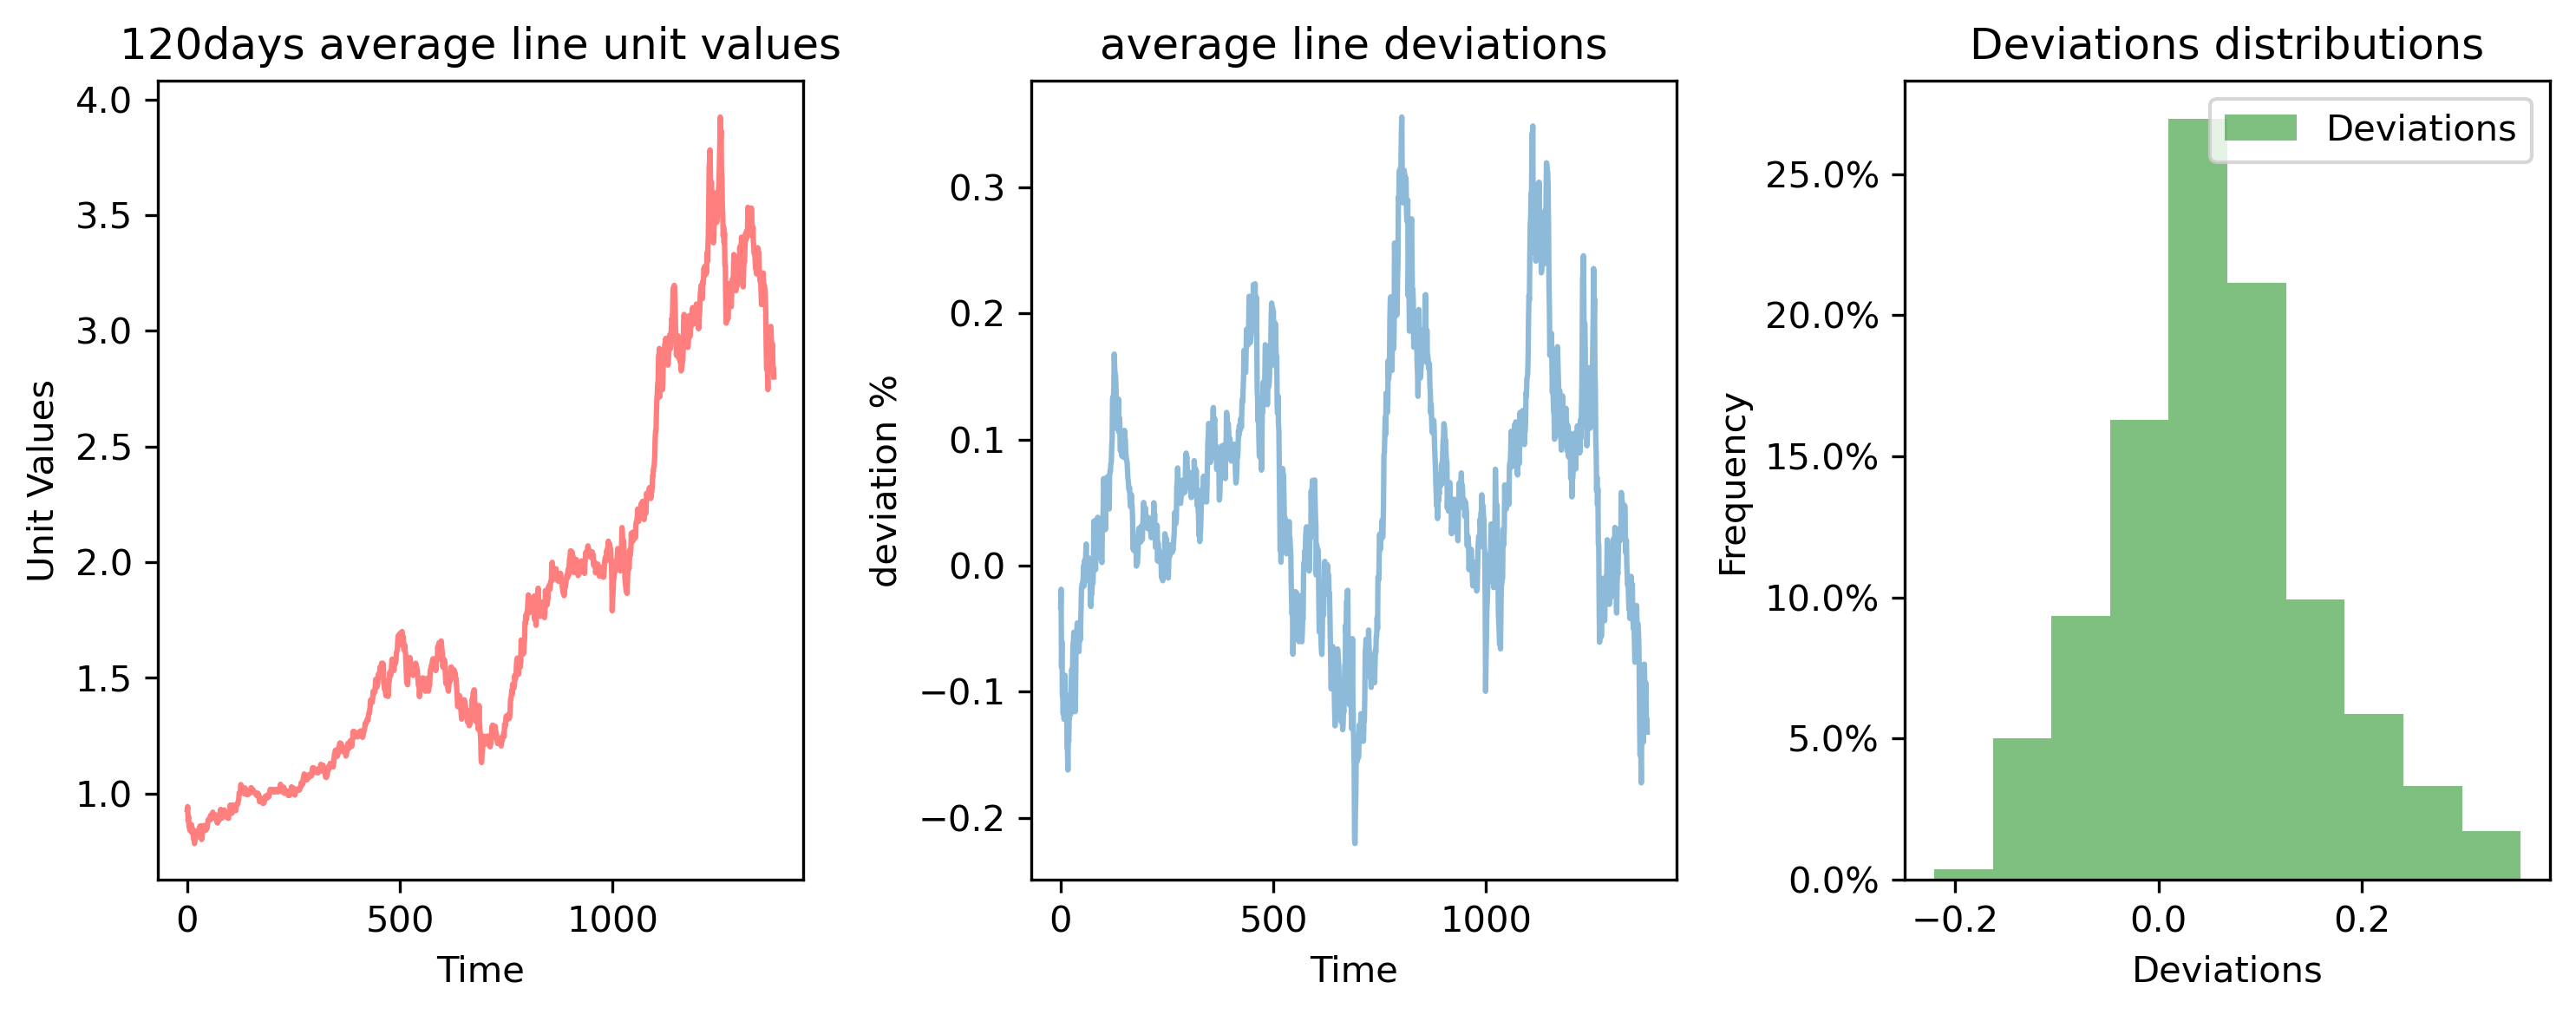

In [30]:
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

avgl = [10,30,60,120]
for lines in range(len(graphs)):
    y = [x for x in range(len(graphs[lines][0]))]
    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))
    #plt.figure()
    plt.subplot(1, 3, 1)
    plt.plot(y,graphs[lines][0],label = 'UnitVals',color = 'r',alpha = 0.5)
    plt.xlabel('Time')
    plt.ylabel('Unit Values')
    plt.title(str(avgl[lines])+'days average line unit values')
    #plt.plot(y,graphs[lines][1],label = 'Avg Lines',alpha = 0.5)
    #plt.figure()
    plt.subplot(1, 3, 2)
    plt.plot(y,graphs[lines][2],label = 'Deviations',alpha = 0.5)
    plt.xlabel('Time')
    plt.ylabel('deviation %')
    plt.title('average line deviations')
    
    plt.subplot(1, 3, 3)
    plt.hist(graphs[lines][2],label = 'Deviations',color = 'g',alpha = 0.5,weights=np.ones(len(graphs[lines][2])) / len(graphs[lines][2]))
    plt.xlabel('Deviations')
    plt.ylabel('Frequency')
    plt.title('Deviations distributions')
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
    
    plt.rcParams['figure.figsize'] = [12, 8]
    plt.rcParams['figure.dpi'] = 300
    plt.legend()
    plt.tight_layout()
    plt.show()

In [31]:
import matplotlib.pyplot as plt

                                               1年10天均线，智能绝对收益: 8796.2178 普通定投: 8173.5967
                                               1年10天均线，智能收益最大: 33.93% 普通定投: 32.84%
                                               1年10天均线，智能收益最小: -20.08% 普通定投: -21.85%
                                               1年10天均线，智能平均收益: 12.77% 普通定投: 12.15%
                                               1年10天均线，智能中位收益: 12.74% 普通定投: 12.65%
                                               1年10天均线，智能方差收益: 11.79% 普通定投: 11.69%
                                               1年10天均线，智能定投胜率: 87.95%
                                               1年10天均线，定投盈利率: 87.55% 普通定投: 87.55%


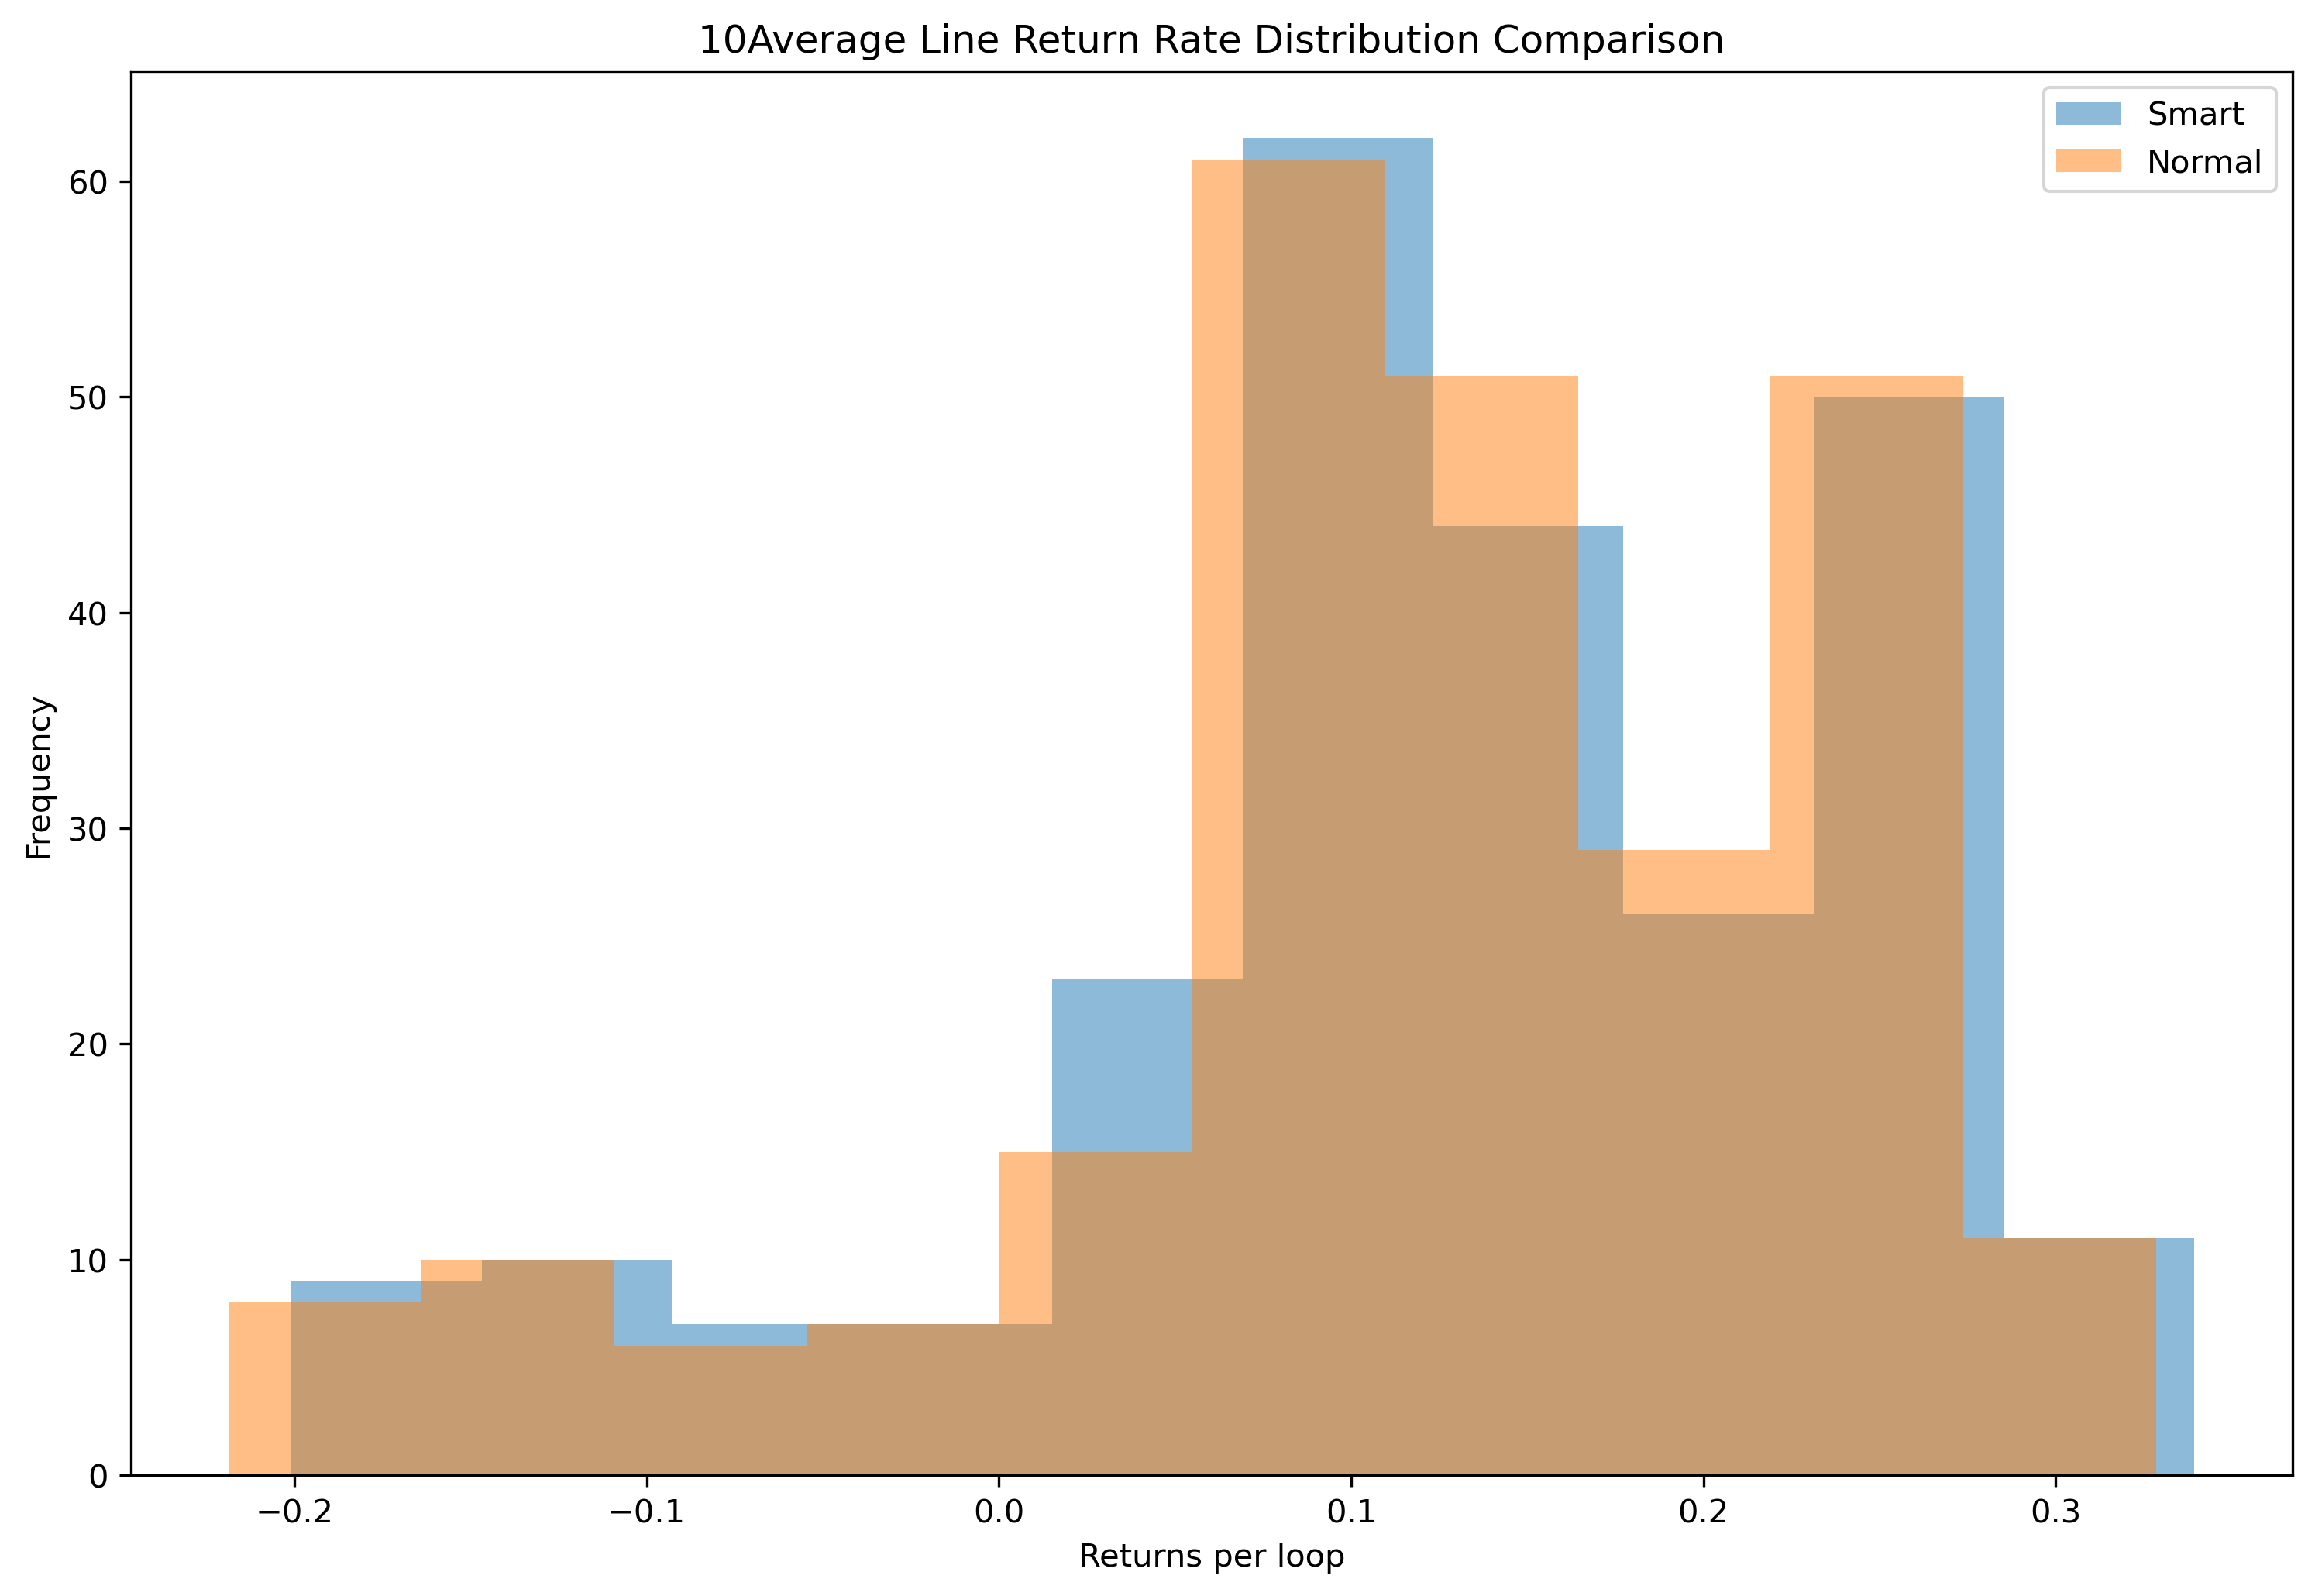

                                               1年30天均线，智能绝对收益: 7889.7064 普通定投: 8173.5967
                                               1年30天均线，智能收益最大: 34.51% 普通定投: 32.84%
                                               1年30天均线，智能收益最小: -19.79% 普通定投: -21.85%
                                               1年30天均线，智能平均收益: 13.09% 普通定投: 12.15%
                                               1年30天均线，智能中位收益: 12.53% 普通定投: 12.65%
                                               1年30天均线，智能方差收益: 11.97% 普通定投: 11.69%
                                               1年30天均线，智能定投胜率: 80.72%
                                               1年30天均线，定投盈利率: 87.55% 普通定投: 87.55%


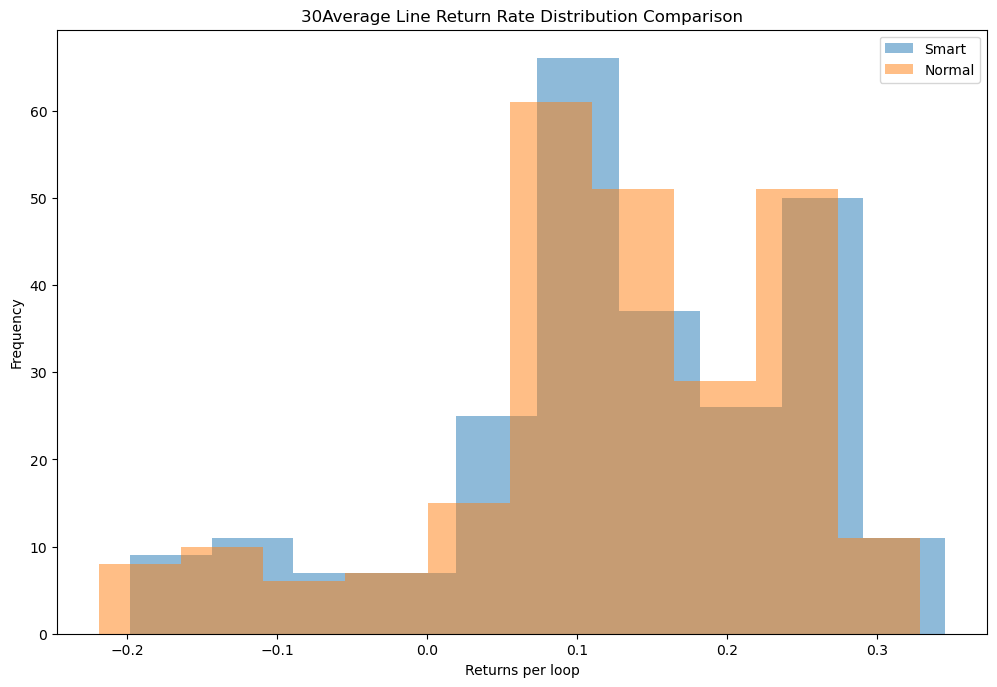

                                               1年60天均线，智能绝对收益: 7607.8175 普通定投: 8173.5967
                                               1年60天均线，智能收益最大: 35.30% 普通定投: 32.84%
                                               1年60天均线，智能收益最小: -19.12% 普通定投: -21.85%
                                               1年60天均线，智能平均收益: 13.48% 普通定投: 12.15%
                                               1年60天均线，智能中位收益: 12.75% 普通定投: 12.65%
                                               1年60天均线，智能方差收益: 12.09% 普通定投: 11.69%
                                               1年60天均线，智能定投胜率: 80.72%
                                               1年60天均线，定投盈利率: 87.55% 普通定投: 87.55%


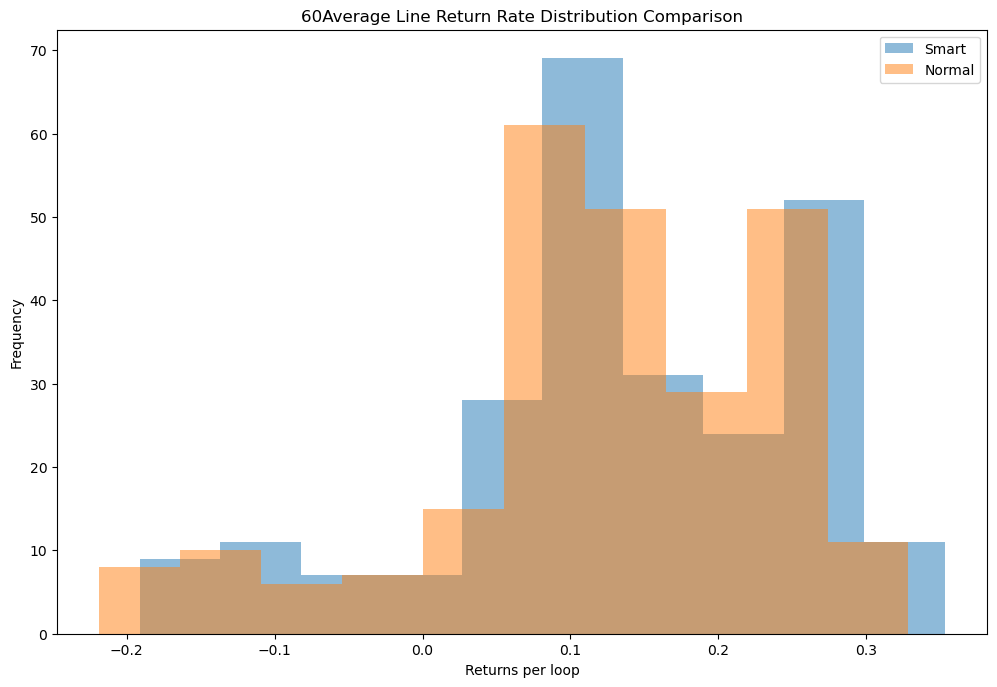

                                               1年120天均线，智能绝对收益: 7649.0488 普通定投: 8173.5967
                                               1年120天均线，智能收益最大: 35.71% 普通定投: 32.84%
                                               1年120天均线，智能收益最小: -18.79% 普通定投: -21.85%
                                               1年120天均线，智能平均收益: 13.79% 普通定投: 12.15%
                                               1年120天均线，智能中位收益: 12.96% 普通定投: 12.65%
                                               1年120天均线，智能方差收益: 12.10% 普通定投: 11.69%
                                               1年120天均线，智能定投胜率: 79.92%
                                               1年120天均线，定投盈利率: 87.55% 普通定投: 87.55%


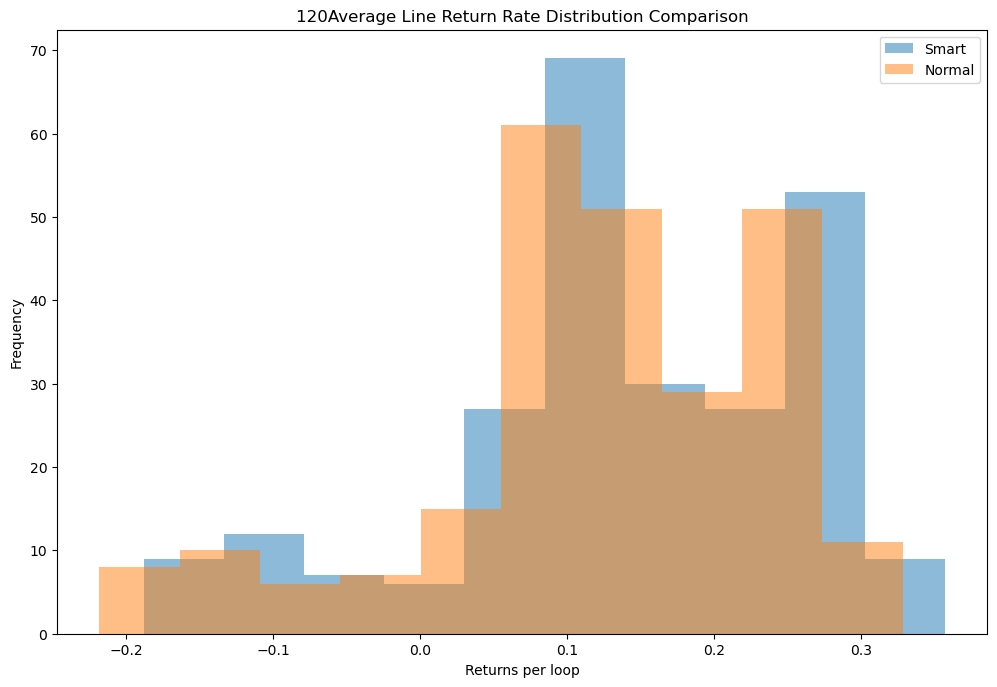

                                               1年10天均线，智能绝对收益: 8796.2178 普通定投: 8173.5967
                                               1年10天均线，智能收益最大: 33.93% 普通定投: 32.84%
                                               1年10天均线，智能收益最小: -20.08% 普通定投: -21.85%
                                               1年10天均线，智能平均收益: 12.77% 普通定投: 12.15%
                                               1年10天均线，智能中位收益: 12.74% 普通定投: 12.65%
                                               1年10天均线，智能方差收益: 11.79% 普通定投: 11.69%
                                               1年10天均线，智能定投胜率: 87.95%
                                               1年10天均线，定投盈利率: 87.55% 普通定投: 87.55%


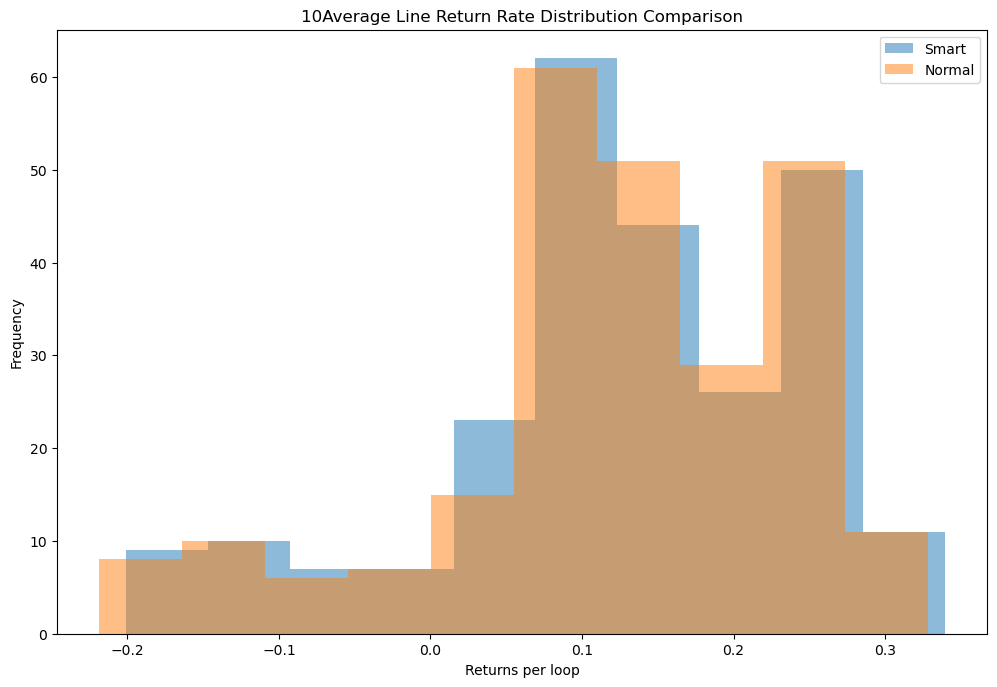

                                               1年30天均线，智能绝对收益: 7889.7064 普通定投: 8173.5967
                                               1年30天均线，智能收益最大: 34.51% 普通定投: 32.84%
                                               1年30天均线，智能收益最小: -19.79% 普通定投: -21.85%
                                               1年30天均线，智能平均收益: 13.09% 普通定投: 12.15%
                                               1年30天均线，智能中位收益: 12.53% 普通定投: 12.65%
                                               1年30天均线，智能方差收益: 11.97% 普通定投: 11.69%
                                               1年30天均线，智能定投胜率: 80.72%
                                               1年30天均线，定投盈利率: 87.55% 普通定投: 87.55%


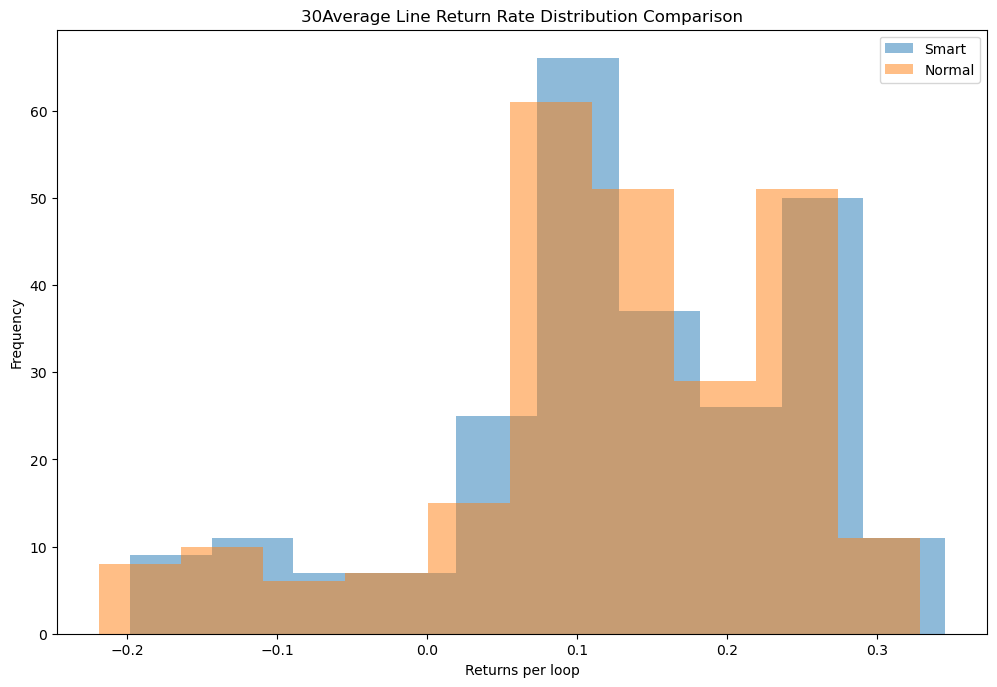

                                               1年60天均线，智能绝对收益: 7607.8175 普通定投: 8173.5967
                                               1年60天均线，智能收益最大: 35.30% 普通定投: 32.84%
                                               1年60天均线，智能收益最小: -19.12% 普通定投: -21.85%
                                               1年60天均线，智能平均收益: 13.48% 普通定投: 12.15%
                                               1年60天均线，智能中位收益: 12.75% 普通定投: 12.65%
                                               1年60天均线，智能方差收益: 12.09% 普通定投: 11.69%
                                               1年60天均线，智能定投胜率: 80.72%
                                               1年60天均线，定投盈利率: 87.55% 普通定投: 87.55%


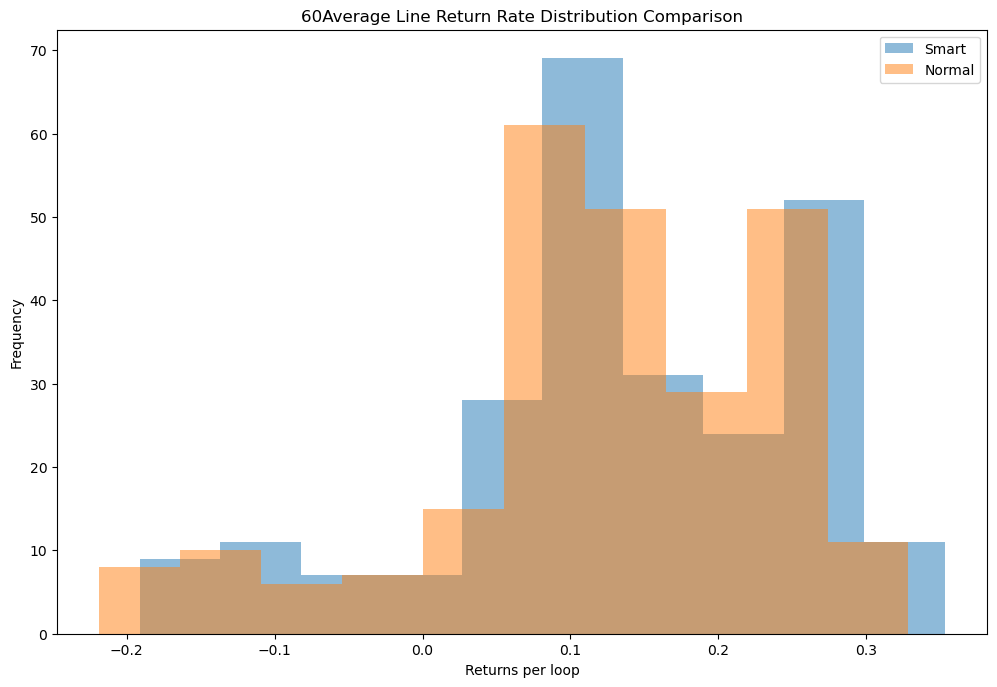

                                               1年120天均线，智能绝对收益: 7649.0488 普通定投: 8173.5967
                                               1年120天均线，智能收益最大: 35.71% 普通定投: 32.84%
                                               1年120天均线，智能收益最小: -18.79% 普通定投: -21.85%
                                               1年120天均线，智能平均收益: 13.79% 普通定投: 12.15%
                                               1年120天均线，智能中位收益: 12.96% 普通定投: 12.65%
                                               1年120天均线，智能方差收益: 12.10% 普通定投: 11.69%
                                               1年120天均线，智能定投胜率: 79.92%
                                               1年120天均线，定投盈利率: 87.55% 普通定投: 87.55%


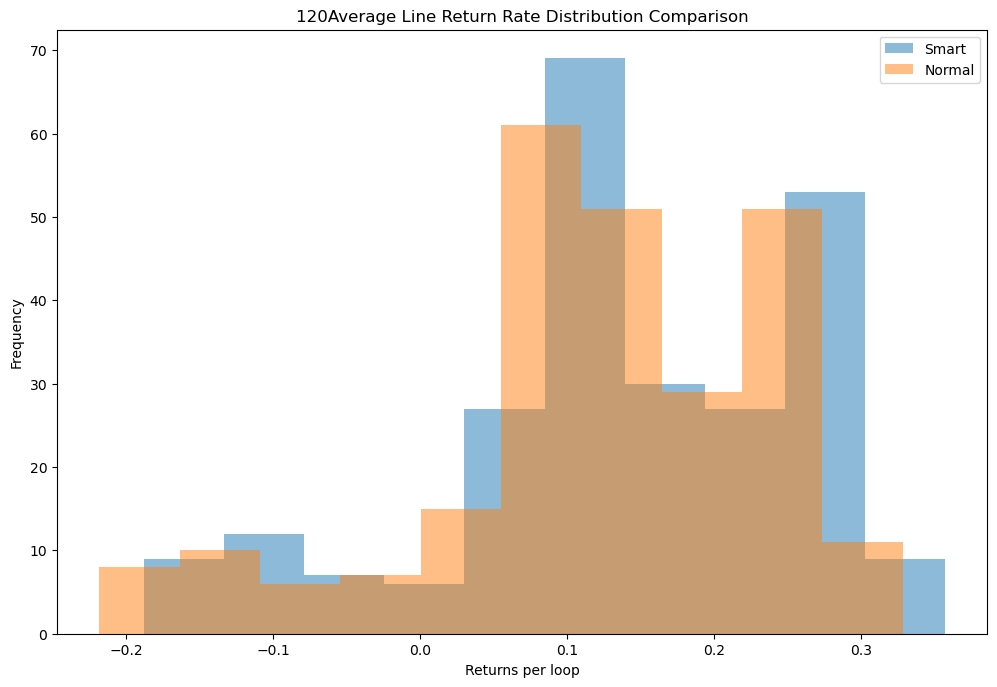

In [32]:
freq = 0
hold = [1,1]
cycle = 0
begin = 5.8
aa = [10,30,60,120]
for h in hold:
    for avgl in aa:
        result = avg_line(gain,price,date,freq,h,cycle,begin,avgl)
        diff = [result[0][x] - result[1][x] for x in range(len(result[0]))]
        winrate = sum([1 for x in diff if x > 0]) / len(result[0])
        winbig = sum([1 for x in result[0] if x > 0]) / len(result[0])
        Nwinbig = sum([1 for x in result[1] if x > 0]) / len(result[0])
        winrate
        print('                                              ',str(h) +'年'+str(avgl) + '天均线，智能绝对收益:',"{:.8}".format(result[3]),'普通定投:',"{:.8}".format(result[4]))
        print('                                              ',str(h) +'年'+str(avgl) + '天均线，智能收益最大:',"{:.2%}".format(max(result[0])),'普通定投:',"{:.2%}".format(max(result[1])))
        print('                                              ',str(h) +'年'+str(avgl) + '天均线，智能收益最小:',"{:.2%}".format(min(result[0])),'普通定投:',"{:.2%}".format(min(result[1])))
        print('                                              ',str(h) +'年' +str(avgl) + '天均线，智能平均收益:',"{:.2%}".format(np.mean(result[0])),'普通定投:',"{:.2%}".format(np.mean(result[1])))
        print('                                              ',str(h) +'年' +str(avgl) + '天均线，智能中位收益:',"{:.2%}".format(np.median(result[0])),'普通定投:',"{:.2%}".format(np.median(result[1])))
        print('                                              ',str(h) +'年' +str(avgl) + '天均线，智能方差收益:',"{:.2%}".format(np.std(result[0])),'普通定投:',"{:.2%}".format(np.std(result[1])))
        print('                                              ',str(h) +'年' +str(avgl) + '天均线，智能定投胜率:',"{:.2%}".format(winrate))
        print('                                              ',str(h) +'年' +str(avgl) + '天均线，定投盈利率:',"{:.2%}".format(winbig),'普通定投:',"{:.2%}".format(Nwinbig))
        plt.figure()
        plt.hist(result[0],label = 'Smart',alpha = 0.5)
        plt.hist(result[1],label = 'Normal',alpha = 0.5)
        plt.xlabel('Returns per loop')
        plt.ylabel('Frequency')
        plt.rcParams['figure.figsize'] = [12, 8]
        plt.rcParams['figure.dpi'] = 100
        plt.title(str(avgl) + 'Average Line Return Rate Distribution Comparison')
        plt.legend()
        plt.show()

In [33]:
ff = [0]
hh = [0.5,0.75,1,1.5,2,2.5,3]
cc = [0]
bb = [4]
aa = [5,10,20,30,60,120,200,250,300,600]

for name in df.columns[1:]:
    price = [x for x in df[name].tolist() if math.isnan(x) == False]
    price.reverse()
    parameters = []
    winrate = []
    alpha = []
    avg_alpha = []
    l = []
    for freq in ff:
        for hold in hh:
            for cycle in cc:
                for begin in bb:
                    for avgl in aa:
                        parameters.append([freq,hold,cycle,begin,avgl])
                        result = avg_line(price,date,freq,hold,cycle,begin,avgl)
                        diff = [result[0][x] - result[1][x] for x in range(len(result[0]))]
                        wr = sum([1 for x in diff if x > 0]) / (len(result[0])+1)
                        al = sum(diff)
                        avg_al = al / (len(result[0])+1)
                        winrate.append(wr)
                        alpha.append(al)
                        avg_alpha.append(avg_al)
                        l.append(len(result[0]))
    max_num = max(winrate)
    max_ind = winrate.index(max(winrate))                    
    print(name,parameters[max_ind], '    胜率:',"{:.2%}".format(max_num),'   总超越收益:',"{:.2%}".format(alpha[max_ind]), '   平均超越收益:', "{:.2%}".format(avg_alpha[max_ind]), '   次数:', l[max_ind])

TypeError: 'int' object is not iterable